# Final Project

### 獲取歷史資料

In [17]:
from finlab.data import Data

data = Data()

rev = data.get("當月營收")
close = data.get("收盤價")

rev.index = rev.index.shift(5, "d")

### 計算features-製作技術指標

In [18]:
def bias(n): #乖離率
    return close / close.rolling(n, min_periods=1).mean()

def acc(n): #加速度
    return close.shift(n) / (close.shift(2*n) + close) * 2

def rsv(n): #RSV
    l = close.rolling(n, min_periods=1).min()
    h = close.rolling(n, min_periods=1).max()
    
    return (close - l) / (h - l)

def mom(n): #動能指標
    return (rev / rev.shift(1)).shift(n)

features = {
    'mom1': mom(1),
    'mom2': mom(2),
    'mom3': mom(3),
    'mom4': mom(4),
    'mom5': mom(5),
    'mom6': mom(6),
    'mom7': mom(7),
    'mom8': mom(8),
    'mom9': mom(9),
    
    'bias5': bias(5),
    'bias10': bias(10),
    'bias20': bias(20),
    'bias60': bias(60),
    'bias120': bias(120),
    'bias240': bias(240),
    
    'acc5': acc(5),
    'acc10': acc(10),
    'acc20': acc(20),
    'acc60': acc(60),
    'acc120': acc(120),
    'acc240': acc(240),
    
    'rsv5': rsv(5),
    'rsv10': rsv(10),
    'rsv20': rsv(20),
    'rsv60': rsv(60),
    'rsv120': rsv(120),
    'rsv240': rsv(240),
}


### 製作dataset

##### 設定買賣頻率

In [19]:
every_month = rev.index
every_month

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2022-03-15', '2022-04-15', '2022-05-15', '2022-06-15',
               '2022-07-15', '2022-08-15', '2022-09-15', '2022-10-15',
               '2022-11-15', '2022-12-15'],
              dtype='datetime64[ns]', name='date', length=215, freq=None)

##### 將dataframe 組裝起來

In [20]:

#將每天的時間序列資料，轉換成每月的時間序列資料
for name, f in features.items():
    features[name] = f.reindex(every_month, method='ffill')

In [21]:

for name, f in features.items():
    features[name] = f.unstack() #將每月的時間序列資料，轉換成每月的欄位資料

In [22]:
import pandas as pd
dataset = pd.DataFrame(features)

In [23]:
feature_names = list(dataset.columns)
feature_names

['mom1',
 'mom2',
 'mom3',
 'mom4',
 'mom5',
 'mom6',
 'mom7',
 'mom8',
 'mom9',
 'bias5',
 'bias10',
 'bias20',
 'bias60',
 'bias120',
 'bias240',
 'acc5',
 'acc10',
 'acc20',
 'acc60',
 'acc120',
 'acc240',
 'rsv5',
 'rsv10',
 'rsv20',
 'rsv60',
 'rsv120',
 'rsv240']

### 新增 label

In [24]:
from finlab import ml

ml.add_profit_prediction(dataset) #預測股票漲跌
ml.add_rank_prediction(dataset) #預測股票排名


### 刪除太大太小的歷史資料

In [25]:
print(dataset.shape)

def drop_extreme_case(dataset, feature_names, thresh=0.01):
    
    extreme_cases = pd.Series(False, index=dataset.index)
    for f in feature_names:
        tf = dataset[f]
        extreme_cases = extreme_cases | (tf < tf.quantile(thresh)) | (tf > tf.quantile(1-thresh))
    dataset = dataset[~extreme_cases]
    return dataset

dataset_drop_extreme_case = drop_extreme_case(dataset, 
    ['bias60', 'bias120', 'bias240', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'mom6'], thresh=0.01)

print(dataset_drop_extreme_case.shape)

(444190, 29)
(416070, 29)


In [26]:
dataset_dropna = dataset_drop_extreme_case.dropna(how='any')
dataset_dropna = dataset_dropna.reset_index().set_index("date")
dataset

mom1      mom2      mom3      mom4      mom5  \
stock_id date                                                           
0015     2005-02-15       NaN       NaN       NaN       NaN       NaN   
         2005-03-15       NaN       NaN       NaN       NaN       NaN   
         2005-04-15       NaN       NaN       NaN       NaN       NaN   
         2005-05-15       NaN       NaN       NaN       NaN       NaN   
         2005-06-15       NaN       NaN       NaN       NaN       NaN   
...                       ...       ...       ...       ...       ...   
9962     2022-08-15  1.694666  0.917472  0.678559  1.435387  1.209077   
         2022-09-15  0.641536  1.694666  0.917472  0.678559  1.435387   
         2022-10-15  1.280940  0.641536  1.694666  0.917472  0.678559   
         2022-11-15  0.830797  1.280940  0.641536  1.694666  0.917472   
         2022-12-15  1.163303  0.830797  1.280940  0.641536  1.694666   

                         mom6      mom7      mom8      mom9     bias5  ...  \
stock_id date                                                          ...   
0015     2005-02-15       NaN       NaN       NaN       NaN       NaN  ...   
         2005-03-15       NaN       NaN       NaN       NaN       NaN  ...   
         2005-04-15       NaN       NaN       NaN       NaN       NaN  ...   
         2005-05-15       NaN       NaN       NaN       NaN       NaN  ...   
         2005-06-15       NaN       NaN       NaN       NaN       NaN  ...   
...                       ...       ...       ...       ...       ...  ...   
9962     2022-08-15  0.859901  0.729493  1.238664  1.033162  1.042199  ...   
         2022-09-15  1.209077  0.859901  0.729493  1.238664  0.974194  ...   
         2022-10-15  1.435387  1.209077  0.859901  0.729493  0.974194  ...   
         2022-11-15  0.678559  1.435387  1.209077  0.859901  0.974194  ...   
         2022-12-15  0.917472  0.678559  1.435387  1.209077  0.974194  ...   

                       acc120    acc240      rsv5     rsv10     rsv20  \
stock_id date                                                           
0015     2005-02-15       NaN       NaN       NaN       NaN       NaN   
         2005-03-15       NaN       NaN       NaN       NaN       NaN   
         2005-04-15       NaN       NaN       NaN       NaN       NaN   
         2005-05-15       NaN       NaN       NaN       NaN       NaN   
         2005-06-15       NaN       NaN       NaN       NaN       NaN   
...                       ...       ...       ...       ...       ...   
9962     2022-08-15  1.031297  1.354003  1.000000  1.000000  1.000000   
         2022-09-15  1.002825  1.668036  0.117647  0.086957  0.142857   
         2022-10-15  1.002825  1.668036  0.117647  0.086957  0.142857   
         2022-11-15  1.002825  1.668036  0.117647  0.086957  0.142857   
         2022-12-15  1.002825  1.668036  0.117647  0.086957  0.142857   

                        rsv60    rsv120    rsv240  return      rank  
stock_id date                                                        
0015     2005-02-15       NaN       NaN       NaN     1.0  0.500416  
         2005-03-15       NaN       NaN       NaN     1.0  0.500416  
         2005-04-15       NaN       NaN       NaN     1.0  0.500416  
         2005-05-15       NaN       NaN       NaN     1.0  0.500416  
         2005-06-15       NaN       NaN       NaN     1.0  0.500416  
...                       ...       ...       ...     ...       ...  
9962     2022-08-15  0.820755  0.386667  0.386667     NaN       NaN  
         2022-09-15  0.623762  0.280000  0.280000     NaN       NaN  
         2022-10-15  0.623762  0.280000  0.280000     NaN       NaN  
         2022-11-15  0.623762  0.280000  0.280000     NaN       NaN  
         2022-12-15  0.623762  0.280000  0.280000     NaN       NaN  

[444190 rows x 29 columns]

In [27]:
# dataset_drop_extreme_case.index.get_level_values("date")
dataset_dropna = dataset_dropna.sort_index()


In [28]:
dataset_train = dataset_dropna.loc[:'2015']
dataset_test = dataset_dropna.loc['2016':]




### 神經網路模型-一般neural network

In [29]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

model = keras.models.Sequential()
model.add(layers.Dense(100, activation='relu',
                      input_shape=(len(feature_names),),
                      kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dense(100, activation='relu',
                      kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(1, activation='sigmoid'))


model.summary()

model.compile(loss='mean_squared_error',
              optimizer="adam",)

print('start fitting')
history = model.fit(dataset_train[feature_names], dataset_train['rank'],
                    batch_size=256,
                    epochs=225,
                    verbose=1,
                    validation_split=0.1, )


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               2800      
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 13,001
Trainable params: 13,001
Non-trainable params: 0
_________________________________________________________________
start fitting
Epoch 1/225
311/311 [==============================] - 1s 3ms/step - loss: 0.0865 - val_loss: 0.0798
Epoch 2/225
311/311 [==============================] - 1s 2ms/step 

### 結果

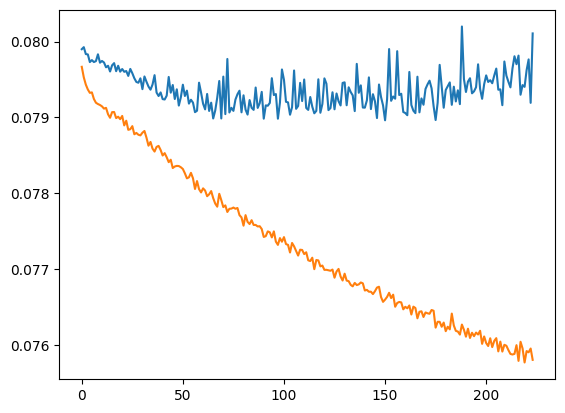

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['val_loss'][1:])
plt.plot(history.history['loss'][1:])

### lightgbm Model

In [31]:
import lightgbm as lgb
cf = lgb.LGBMRegressor(n_estimators=500)
cf.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 88303, number of used features: 27
[LightGBM] [Info] Start training from score 0.502753


LGBMRegressor(n_estimators=500)

### Random Forest Model

In [32]:
from sklearn.ensemble import RandomForestRegressor

cf2 = RandomForestRegressor(n_estimators=100)
cf2.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

RandomForestRegressor()

<Axes: xlabel='Value', ylabel='Feature'>

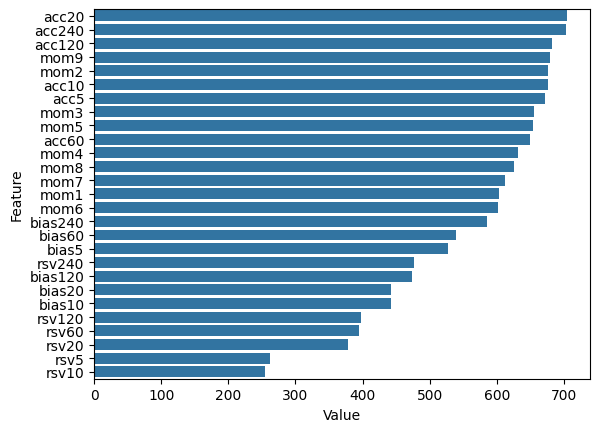

In [33]:
feature_imp = pd.DataFrame(zip(cf.feature_importances_, feature_names), 
                           columns=['Value','Feature']).sort_values('Value', ascending=False)
feature_imp

%matplotlib inline
import seaborn as sns
sns.barplot(x="Value", y="Feature", data=feature_imp)

### Ensemble learning

In [35]:
dataset_drop = dataset.dropna(subset=feature_names+['return'])

vals = model.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result1'] = pd.Series(vals.swapaxes(0,1)[0], dataset_drop.index)

vals = cf.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result2'] = pd.Series(vals, dataset_drop.index)

vals = cf2.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result3'] = pd.Series(vals, dataset_drop.index)



dataset_drop = dataset_drop.reset_index().set_index("date")

6561/6561 [==============================] - 6s 836us/step


C:\Users\jerry\AppData\Local\Temp\ipykernel_19004\3847599684.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_drop['result1'] = pd.Series(vals.swapaxes(0,1)[0], dataset_drop.index)
C:\Users\jerry\AppData\Local\Temp\ipykernel_19004\3847599684.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_drop['result2'] = pd.Series(vals, dataset_drop.index)
C:\Users\jerry\AppData\Local\Temp\ipykernel_19004\3847599684.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

# backtest

C:\Users\jerry\AppData\Local\Temp\ipykernel_19004\2011488552.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pd.DataFrame({'nn strategy return':rs.reindex(s0050.index, method='ffill'), '0050 return':s0050/s0050[0]}).plot()


<Axes: xlabel='date'>

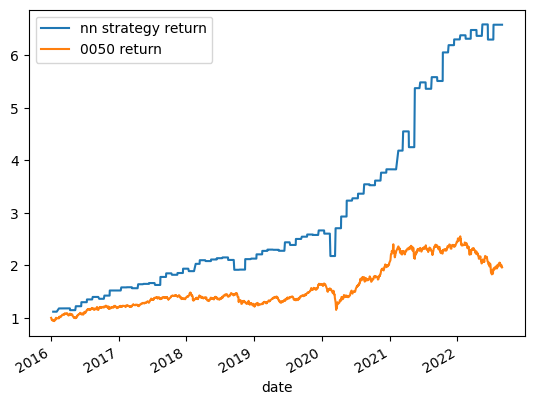

In [37]:
import math


dates = sorted(list(set(dataset_drop.index)))

rs = []
for d in dates:
    
    dataset_time = dataset_drop.loc[d]
    
    dataset_time = drop_extreme_case(dataset_time, 
        ['bias60', 'bias120', 'bias240', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'mom6'], thresh=0.01)
    
    rank = dataset_time['result1'] + dataset_time['result2'] + dataset_time['result3'] #三個模型的預測結果相加
    
    condition = (rank >= rank.nlargest(20).iloc[-1]) #取前20名
    r = dataset_time['return'][condition].mean() #取前20名的平均報酬率

    rs.append(r * (1-3/1000-1.425/1000*2*0.6))

rs = pd.Series(rs, index=dates)['2016':].cumprod()

s0050 = close['0050']['2016':] #0050指數跟大盤比較

pd.DataFrame({'nn strategy return':rs.reindex(s0050.index, method='ffill'), '0050 return':s0050/s0050[0]}).plot()



### 當月持股狀況

In [38]:
dataset.index.levels[1]

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2022-03-15', '2022-04-15', '2022-05-15', '2022-06-15',
               '2022-07-15', '2022-08-15', '2022-09-15', '2022-10-15',
               '2022-11-15', '2022-12-15'],
              dtype='datetime64[ns]', name='date', length=215, freq=None)

42/42 [==============================] - 0s 902us/step


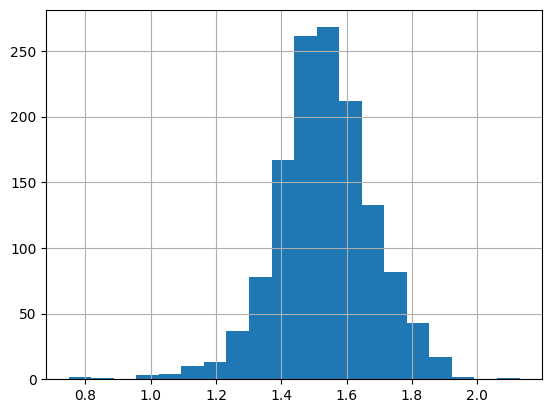

In [39]:
# get the latest dataset
last_date = "2019-07-15"#dataset.index.levels[1].max()
is_last_date = dataset.index.get_level_values('date') == last_date
last_dataset = dataset[is_last_date].copy()


last_dataset = drop_extreme_case(last_dataset, 
    ['bias60', 'bias120', 'bias240', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'mom6'], thresh=0.01)


# remove NaN testcases
last_dataset = last_dataset.dropna(subset=feature_names)

# predict

vals = model.predict(last_dataset[feature_names].astype(float))
last_dataset['result1'] = pd.Series(vals.swapaxes(0,1)[0], last_dataset.index)

vals = cf.predict(last_dataset[feature_names].astype(float))
last_dataset['result2'] = pd.Series(vals, last_dataset.index)

vals = cf2.predict(last_dataset[feature_names].astype(float))
last_dataset['result3'] = pd.Series(vals, last_dataset.index)


# calculate score

rank = last_dataset['result1'] + last_dataset['result2'] + last_dataset['result3']
condition = (rank >= rank.nlargest(20).iloc[-1]) 

# plot rank distribution
rank.hist(bins=20)


# show the best 20 stocks
slist1 = rank[condition].reset_index()['stock_id']





# 平均分配資產於股票之中

In [40]:
close = data.get("收盤價")

money = 1000000
stock_prices = close[rank[condition].reset_index()['stock_id']].iloc[-1]


print("股票平分張數:")
money / len(stock_prices) / stock_prices / 1000


股票平分張數:


stock_id
1216    0.762195
1584    2.500000
1788    0.310559
1907    2.066116
2511    4.166667
2643    0.695410
2801    2.865330
2836    3.663004
2845    4.149378
2849    3.424658
2906    2.724796
3206    1.824818
3528    0.980392
5403    0.692521
5530    1.199041
6201    1.253133
8032    1.579779
9908    1.529052
9917    0.485437
9925    1.257862
Name: 2022-08-30 00:00:00, dtype: float64